In [0]:
import pandas as pd
import tqdm 

## NN model

In [0]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,y
0,0,33,Private,34,26,Masters degree(MA MS MEng MEd MSW MBA),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Adm support including clerical,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,?,?,?,Not in universe under 1 year old,?,6,Not in universe,China,China,Taiwan,Foreign born- Not a citizen of U S,2,Not in universe,2,52,95,50000+.
1,1,63,Private,7,22,Some college but no degree,0,Not in universe,Never married,Manufacturing-durable goods,Adm support including clerical,White,All other,Female,Not in universe,Not in universe,Full-time schedules,0,0,0,Single,Not in universe,Not in universe,Nonfamily householder,Householder,?,?,?,Not in universe under 1 year old,?,4,Not in universe,?,?,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
2,2,71,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Germany,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
3,3,43,Local government,43,10,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Education,Professional specialty,White,All other,Female,Yes,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,?,?,?,Not in universe under 1 year old,?,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
4,4,57,Local government,40,32,Some college but no degree,0,Not in universe,Widowed,Entertainment,Other service,Amer Indian Aleut or Eskimo,All other,Female,Not in universe,Not in universe,Full-time schedules,0,0,0,Head of household,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.


In [0]:
from fastai.tabular import * 

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
df = df.drop(['id'],axis=1)

In [0]:
dep_var = 'y'

In [8]:
df.describe()

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
count,54256.000000,54256.000000,54256.000000,54256.000000,54256.000000,54256.000000,54256.000000,54256.000000,54256.000000,54256.000000,54256.000000,54256.000000
mean,40.881967,21.868107,14.878613,76.561099,1152.446734,68.237098,432.622162,2.817827,0.243402,1.869120,33.459230,94.492628
std,18.435235,18.019882,14.592449,336.404991,8086.570381,367.116868,3326.139032,2.405924,0.636459,0.480408,22.990531,0.499950
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,40.000000,29.000000,11.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,52.000000,94.000000
75%,52.000000,38.000000,29.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.000000,4356.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


In [0]:
cat_names = [ 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 
       'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
       'own business or self employed',
       "fill inc questionnaire for veteran's admin", 'veterans benefits',
       'year']

In [10]:
len(df)

54256

In [0]:
valid_idx = range(len(df)-8000, len(df))

In [0]:
procs = [FillMissing, Categorify, Normalize]

In [0]:
data = TabularDataBunch.from_df(path='',df= df,dep_var= dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)

In [0]:
test = pd.read_csv('test_no_label.csv')
test = test.drop(['id'],axis=1)

In [0]:
learn = tabular_learner(data, layers=[1000,2000], metrics=accuracy, wd=0.1)

In [19]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


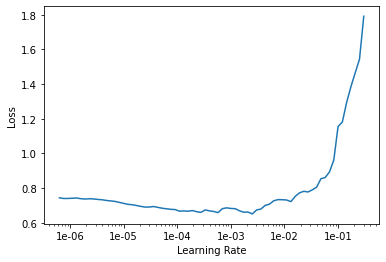

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.376634,0.328906,0.875625,00:53
1,0.303148,0.276817,0.881875,00:53
2,0.264366,0.271932,0.884000,00:53


In [0]:
learn.save('stage1')

In [23]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.266069,0.273372,0.884750,00:53


In [0]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.273746,0.285133,0.875500,00:54


In [0]:
learn.save('stage2')

In [0]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.279791,0.289142,0.871625,00:54


In [0]:
learn.load('stage1');

In [25]:
test

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year
0,37,Private,42,30,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Medical except hospital,Other service,White,All other,Female,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,?,?,?,Not in universe under 1 year old,?,4,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95
1,48,Private,31,35,High school graduate,0,Not in universe,Married-civilian spouse present,Utilities and sanitary services,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95
2,68,Not in universe,0,0,High school graduate,0,Not in universe,Married-spouse absent,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Single,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,94
3,74,Private,12,36,11th grade,700,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,White,All other,Male,No,Not in universe,Full-time schedules,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,5,Not in universe,Poland,Poland,United-States,Native- Born in the United States,0,Not in universe,2,52,95
4,18,Federal government,50,14,Some college but no degree,0,Not in universe,Never married,Public administration,Technicians and related support,White,All other,Male,Not in universe,Re-entrant,Unemployed full-time,0,0,0,Nonfiler,Not in universe,Not in universe,Secondary individual,Nonrelative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27617,42,Federal government,49,15,Bachelors degree(BA AB BS),0,Not in universe,Never married,Public administration,Technicians and related support,White,All other,Male,Not in universe,Re-entrant,Children or Armed Forces,0,0,0,Single,South,Oregon,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,No,1,9,94
27618,40,Private,19,39,Some college but no degree,1600,Not in universe,Married-civilian spouse present,Manufacturing-nondurable goods,Transportation and material moving,Black,All other

In [26]:
test.columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
       'own business

In [0]:
fill_missing = FillMissing(cat_names = cat_names, cont_names=['age','wage per hour','capital gains','capital losses','weeks worked in year', 'dividends from stocks'])

In [0]:
fill_missing(test)

In [29]:
pred = []
for i in tqdm.notebook.tqdm(range(len(test))):
  _,a,_ = learn.predict(test.iloc[i])
  pred.append(str(a.item()))

In [0]:
sub = pd.DataFrame()
sub['id'] = [i for i in np.arange(len(pred))]
sub['label'] = pred

In [33]:
sub.head()

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [0]:
sub.to_csv('submission_nn_fastai.csv',index=False)

## LGB

In [0]:
X_train = pd.read_csv('X_train')

In [0]:
Y_train = pd.read_csv('Y_train')

In [0]:
X_test = pd.read_csv('X_test')

In [0]:
df = X_train.copy()

In [0]:
df['label'] = Y_train.label

### Create folds

In [0]:
from sklearn.model_selection import StratifiedKFold
def folds(df):
  df['kfold'] = -1
  df = df.sample(frac=1).reset_index(drop=True)
  kf = StratifiedKFold(n_splits=7, shuffle=False)
  for fold, (trainindex ,validationindex) in enumerate(kf.split(X=df, y=df.label.values)):
    df.loc[validationindex, 'kfold']= fold+1
  return df

In [0]:
df.head()

,id,age,Private,Self-employed-incorporated,State government,Self-employed-not incorporated,Not in universe,Without pay,Federal government,Never worked,Local government,10,11,38,13,14,15,16,17,32,33,30,31,36,37,34,35,39,23,48,50,18,19,42,25,24,12,26,21,20,...,Honduras.2,Mexico.2,Portugal.2,England.2,Jamaica.2,India.2,Yugoslavia.2,Greece.2,Japan.2,Taiwan.2,?.7,Hong Kong.2,Canada.2,Italy.2,Panama.2,Scotland.2,France.2,Cambodia.2,Ecuador.2,Laos.2,Peru.2,Ireland.2,Native- Born in Puerto Rico or U S Outlying,Native- Born abroad of American Parent(s),Foreign born- U S citizen by naturalization,Native- Born in the United States,Foreign born- Not a citizen of U S,2.2,0.2,1.2,Not in universe.12,Yes.3,No.3,2.3,0.3,1.3,weeks worked in year,94,95,label
0,0,33,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,52,0,1,1
1,1,63,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,52,0,1,0
2,2,71,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0
3,3,43,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,52,0,1,0
4,4,57,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,52,0,1,0


In [0]:
df = folds(df)
df.head()

,id,age,Private,Self-employed-incorporated,State government,Self-employed-not incorporated,Not in universe,Without pay,Federal government,Never worked,Local government,10,11,38,13,14,15,16,17,32,33,30,31,36,37,34,35,39,23,48,50,18,19,42,25,24,12,26,21,20,...,Mexico.2,Portugal.2,England.2,Jamaica.2,India.2,Yugoslavia.2,Greece.2,Japan.2,Taiwan.2,?.7,Hong Kong.2,Canada.2,Italy.2,Panama.2,Scotland.2,France.2,Cambodia.2,Ecuador.2,Laos.2,Peru.2,Ireland.2,Native- Born in Puerto Rico or U S Outlying,Native- Born abroad of American Parent(s),Foreign born- U S citizen by naturalization,Native- Born in the United States,Foreign born- Not a citizen of U S,2.2,0.2,1.2,Not in universe.12,Yes.3,No.3,2.3,0.3,1.3,weeks worked in year,94,95,label,kfold
0,32474,50,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,52,1,0,0,1
1,24406,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,26,1,0,0,1
2,34956,43,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,50,1,0,1,1
3,48063,50,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,46,0,1,0,1
4,32832,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,40,0,1,0,1


In [0]:
import lightgbm as lgb

### Training

In [0]:
def lgbtrainer(df, fold):
    train_df = df[df.kfold != fold]
    valid_df = df[df.kfold == fold]
    y_train = train_df.label.values
    y_valid = valid_df.label.values
    x_train = train_df.drop(['label','kfold'],axis=1)
    x_valid = valid_df.drop(['label','kfold'],axis=1)
    x_valid = x_valid[x_train.columns]
    #create lgb datasets
    train_data = lgb.Dataset(x_train, label=y_train)
    validation_data = lgb.Dataset(x_valid, label = y_valid, reference=train_data)
    #training
    param = {'num_leaves':31,  'learning_rate':0.1, 'num_iterations': 400,  'seed': 42, 'metric':'binary_error','objective': 'binary'}
    bst = lgb.train(param, train_data, valid_sets=[validation_data],verbose_eval=False)
    return bst

In [0]:
lgb1 = lgbtrainer(df, fold=1)
lgb2 = lgbtrainer(df, fold=2)
lgb3 = lgbtrainer(df, fold=3)
lgb4 = lgbtrainer(df, fold=4)
lgb5 = lgbtrainer(df, fold=5)
lgb6 = lgbtrainer(df, fold=6)
lgb7 = lgbtrainer(df, fold=7)
final = (lgb1.predict(X_test) +  lgb2.predict(X_test) +  lgb3.predict(X_test)+ lgb4.predict(X_test) + lgb5.predict(X_test)+ lgb6.predict(X_test) +  lgb7.predict(X_test))/7

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [0]:
def lgbtrainer(df, fold):
    train_df = df[df.kfold != fold]
    valid_df = df[df.kfold == fold]
    y_train = train_df.label.values
    y_valid = valid_df.label.values
    x_train = train_df.drop(['label','kfold'],axis=1)
    x_valid = valid_df.drop(['label','kfold'],axis=1)
    x_valid = x_valid[x_train.columns]
    #create lgb datasets
    train_data = lgb.Dataset(x_train, label=y_train)
    validation_data = lgb.Dataset(x_valid, label = y_valid, reference=train_data)
    #training
    param = {'num_leaves':40,  'learning_rate':0.08, 'num_iterations': 400,  'seed': 128, 'metric':'binary_error','objective': 'binary'}
    bst = lgb.train(param, train_data, valid_sets=[validation_data],verbose_eval=False)
    return bst

In [0]:
lgb1 = lgbtrainer(df, fold=1)
lgb2 = lgbtrainer(df, fold=2)
lgb3 = lgbtrainer(df, fold=3)
lgb4 = lgbtrainer(df, fold=4)
lgb5 = lgbtrainer(df, fold=5)
lgb6 = lgbtrainer(df, fold=6)
lgb7 = lgbtrainer(df, fold=7)
final2 = (lgb1.predict(X_test) +  lgb2.predict(X_test) +  lgb3.predict(X_test)+ lgb4.predict(X_test) + lgb5.predict(X_test)+ lgb6.predict(X_test) +  lgb7.predict(X_test))/7

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [0]:
pred = []
for i in  (final1+final2)/2:
  if i < 0.5:
    pred.append('0')
  else:
    pred.append('1')

In [0]:
sub.label = pred

In [0]:
sub.to_csv('submission_3.csv',index=False)

## Random Forest Models

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
def rftrainer(df, fold):
    train_df = df[df.kfold != fold]
    valid_df = df[df.kfold == fold]
    y_train = train_df.label.values
    y_valid = valid_df.label.values
    x_train = train_df.drop(['label','kfold'],axis=1)
    x_valid = valid_df.drop(['label','kfold'],axis=1)
    x_valid = x_valid[x_train.columns]
    rfc = RandomForestClassifier(n_estimators = 200, n_jobs=-1, verbose=0, random_state=128) 
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_valid)
    print('the score you had for this fold is: ', metrics.accuracy_score(preds, y_valid))
    return rfc

In [0]:
rf1 = rftrainer(df, fold=1)

the score you had for this fold is:  0.8837569345890853


In [0]:
rf2 = rftrainer(df, fold=2)

the score you had for this fold is:  0.8818217004257515


In [0]:
rf3= rftrainer(df, fold=3)

the score you had for this fold is:  0.8809185911495291


In [0]:
rf4= rftrainer(df, fold=4)

the score you had for this fold is:  0.8846600438653077


In [0]:
rf5 = rftrainer(df, fold=5)

the score you had for this fold is:  0.8874983873048639


In [0]:
rf6 = rftrainer(df, fold=6)

the score you had for this fold is:  0.8890465746355309


In [0]:
rf7 = rftrainer(df, fold=7)

the score you had for this fold is:  0.8819354838709678


In [0]:
finalrf = (pd.DataFrame(rf1.predict_proba(X_test), columns=['a','b']).b +
           pd.DataFrame(rf2.predict_proba(X_test), columns=['a','b']).b +
           pd.DataFrame(rf3.predict_proba(X_test), columns=['a','b']).b +
           pd.DataFrame(rf4.predict_proba(X_test), columns=['a','b']).b +
           pd.DataFrame(rf5.predict_proba(X_test), columns=['a','b']).b +
           pd.DataFrame(rf6.predict_proba(X_test), columns=['a','b']).b +
           pd.DataFrame(rf7.predict_proba(X_test), columns=['a','b']).b ) / 7
finalrf

0        0.060714
1        0.512143
2        0.032143
3        0.216429
4        0.067143
           ...   
27617    0.303571
27618    0.170000
27619    0.899286
27620    0.000000
27621    0.054286
Name: b, Length: 27622, dtype: float64

In [0]:
pred = []
for i in  finalrf:
  if i < 0.5:
    pred.append('0')
  else:
    pred.append('1')

In [0]:
sub.label = pred
sub.to_csv('submission_rf.csv',index=False)

In [0]:
pred = []
for i in (finalrf*.2 + final1*.4 + final2*.4):
  if i < 0.5:
    pred.append('0')
  else:
    pred.append('1')

In [0]:
sub.label = pred
sub.to_csv('submission_ensemble.csv',index=False)

This can get me first place in KDD dataset. Public = 0.90275, Public = 0.90558. This is a past competition.